In [132]:
import os
import pandas as pd
from sklearn import preprocessing
import numpy as np
import seaborn as sns

In [74]:
EVENT_FOLDER = './events_csv'
EVENT_FILES = os.listdir(EVENT_FOLDER)

event_list = []
event_names = ['Dallas', 'New Orleans', 'Atlanta', 'Birmingham', ' Pro League 1', 'Relegation', 'Seattle',
               'Anaheim', 'Pro League 2', 'Champs']
event_dict = {}
ww2_snd = []

for x in EVENT_FILES:
    with open('{}/{}'.format(EVENT_FOLDER, x)) as f:
        temp = pd.read_csv(f)
        event_list.append(temp)

event_dict = dict(zip(event_names, event_list))

meta_df = pd.concat(event_list[:])

ww2_snd = meta_df[meta_df['mode'] == 'Search & Destroy']

Slecting the desired variables, removing weapons that were seen to distort the model, and reclassyfying necessary data types. p_df_filt will be the reference dataset for each statistic calcuation.

In [80]:
# stats to be used in model
target_stats = ['match id','player', 'fave weapon', 'kills', 'kills (stayed alive)', 'shots', 
                'time alive (s)', 'snd firstbloods', 'scorestreaks earned', 'snd rounds']

# objects within 'fave weapon' that influence model results
n2low = ['M1 Garand', 'M1941']
distort = ['Kar98k', 'Springfield'] + n2low

# subsetting for stats, removing distorting weapons, and converting necessary columns to numeric.
p_df = ww2_snd[target_stats]
p_df_filt = p_df[~p_df['fave weapon'].isin(distort)].copy()
p_df_filt['time alive (s)'] = pd.to_numeric(p_df_filt['time alive (s)'], errors="coerce")

Each statistic will be calculated in its own dataframe. This may not be the fatest solution but it is the easiest method for visualizing this in my head.

Calculating the average kill per round stat and each players residual value:

In [81]:
akpr = p_df_filt.groupby('player')['kills', 'snd rounds'].sum()
akpr = akpr[akpr['snd rounds'] > 25]
akpr['akpr'] = akpr['kills']/akpr['snd rounds']
akpr_mu = akpr['akpr'].mean()
akpr['akpr.resid']= akpr['akpr']-akpr_mu

# storing residual into running residual storage list for later calcualtion

resid_list = [akpr['akpr.resid']]

Calculating the average non traded kill per round stat and each players residual value:

In [82]:
antkpr = p_df_filt.groupby('player')['kills (stayed alive)', 'snd rounds'].sum()
antkpr = antkpr[antkpr['snd rounds'] > 25]
antkpr['antkpr'] = antkpr['kills (stayed alive)']/antkpr['snd rounds']
antkpr_mu = antkpr['antkpr'].mean()
antkpr['antkpr.resid']= antkpr['antkpr']-antkpr_mu

# storing residual into running residual storage list for later calcualtion

resid_list = resid_list + [antkpr['antkpr.resid']]

Calculating the average shots per round stat and each players residual value:

In [83]:
aspr = p_df_filt.groupby('player')['shots', 'snd rounds'].sum()
aspr = aspr[aspr['snd rounds'] > 25]
aspr['aspr'] = aspr['shots']/aspr['snd rounds']
aspr_mu = aspr['aspr'].mean()
aspr['aspr.resid']= aspr['aspr']-aspr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [aspr['aspr.resid']]

Calculating the average time per life stat and each players residual value:

In [84]:
atapr = p_df_filt.groupby('player')['time alive (s)', 'snd rounds'].sum()
atapr = atapr[atapr['snd rounds'] > 25]
atapr['atapr'] = atapr['time alive (s)']/atapr['snd rounds']
atapr_mu = atapr['atapr'].mean()
atapr['atapr.resid']= atapr['atapr']-atapr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [atapr['atapr.resid']]

Calculating the average firstblood per round stat and each players residual value:

In [85]:
afbpr = p_df_filt.groupby('player')['snd firstbloods', 'snd rounds'].sum()
afbpr = afbpr[afbpr['snd rounds'] > 25]
afbpr['afbpr'] = afbpr['snd firstbloods']/afbpr['snd rounds']
afbpr_mu = afbpr['afbpr'].mean()
afbpr['afbpr.resid']= afbpr['afbpr']-afbpr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [afbpr['afbpr.resid']]

Calculating the average score streak per round stat and each players residual value:

In [86]:
astpr = p_df_filt.groupby('player')['scorestreaks earned', 'snd rounds'].sum()
astpr = astpr[astpr['snd rounds'] > 25]
astpr['astpr'] = astpr['scorestreaks earned']/astpr['snd rounds']
astpr_mu = astpr['astpr'].mean()
astpr['astpr.resid']= astpr['astpr']-astpr_mu

# storing residual into running residual storage list for later calcualtion
resid_list = resid_list + [astpr['astpr.resid']]

Taking the mean of each statistics residual. Will use the mean to normalize each stat so no one stat is weighted more than the others due to the scale in their inherent variances.

In [142]:
resids = pd.concat(resid_list, axis=1)
test = resids.drop(columns = 'akpr.resid')
test

scaled = test.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
test
test['antkpr.resid'].nlargest(10)
                   

player
Weeman     0.263733
Legal      0.222619
Abezy      0.221629
mosh       0.175611
Kismet     0.171337
Dashy      0.136081
Denza      0.135742
Denz       0.124459
Slasher    0.124235
Zoomaa     0.120997
Name: antkpr.resid, dtype: float64

Now that the data is scaled (still need to review standardization method as not exactly confident), the next step is to enact the summation of each player's statistic to output the rating.

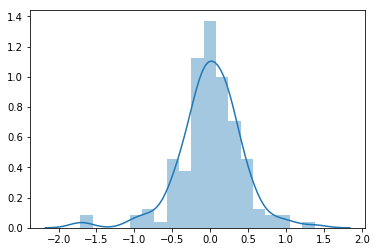

In [134]:
sums = scaled.sum(axis=1)
sns.distplot(sums)